# GMM UBM

Jednym ze sposobów weryfikacji mówcy stosowanym od dawna jest `GMM-UBM`. Polega on na utworzeniu modelu tła
(_universal background model_), modelu mikstur gaussowskich i dopasowaniu ich do ramek `MFCC` z nagrań
treningowych. Następnie, do każdego mówcy tworzony jest osobny model przez `MAP` adaptację modelu tła do nagrań danego
mówcy. 

W
_Utterance Verification for Text-Dependent Speaker Recognition: aComparative Assessment Using the RedDots Corpus_
następnie dokonywane liczona jest różnica między logarytmem prawdopodobieństwa wygenerowania nagrania przez model
dla mówcy i przez model tła. Różnica ta porównywana jest z progiem i na tej podstawie podejmowana jest decyzja
o weryfikacji. Podobnie można weryfikować treść nagrania, przez adaptację modelu tła do nagrań konkretnej treści.
Jeżeli treść wszystkich wypowiedzi jest znana i jest to zbiór zamknięty, to zamiast porównywać model dla jednej
treści z modelem tła, radzą wykorzystać _mean norm_ lub _max norm_. To znaczy porównać wynik weryfikowanego
modelu ze średnim wynikiem pozostałych lub z najlepszym wynikiem pozostałych. Autorzy mają podejście, by niezależnie
zweryfikować mówcę i treść wypowiedzi.

Autorzy testują wiele modeli, w tym zarówno do weryfikacji mówcy i treści mają \shortcut{GMM-UBM} z 512 miksturami.
Jako cechy używają 19 `MFCC` z delta i delta-delta cechami. `MAP`-adaptacja z _relevance factor_ 3.
Do weryfikacji mówcy przy adaptacji korzystają z nagrań tego mówcy, a do weryfikacji treści nagrań tej samej treści.

In [1]:
%load_ext autoreload

In [50]:
%autoreload 2

import concurrent.futures as cf
import functools as ft
import itertools as it
import json
import math
import operator as op
import os
import re

from IPython.display import display
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import interpolate, linalg, misc, optimize, spatial, stats
from sklearn import metrics, mixture, cluster, utils

from paprotka.dataset import reddots
from paprotka.feature import cepstral

In [51]:
%autoreload 0

In [4]:
import warnings
warnings.filterwarnings('once')

# Load

In [18]:
root = reddots.get_root()
load_pcm = ft.partial(reddots.load_pcm, root)
load_mfcc = ft.partial(reddots.load_npy, root, 'wac2_mfcc13_ddd_lifter22_hamming') # 'wac2_mfcc13_ddd_ne_hamming')

In [19]:
all_paths = [os.path.join(os.path.basename(root), file) for root, _, files in os.walk(root + '/pcm') 
                                      for file in files 
                                      if file.endswith('.pcm')]
print(len(all_paths), all_paths[0])

15305 f0002/20150224142650384_f0002_14438.pcm


In [20]:
all_mfcc = {path: load_mfcc(path) for path in all_paths}

In [8]:
def load_sets(eid, tid=None):
    tid = tid if tid else eid
    
    enrollments = reddots.load_enrollments(root + '/ndx/f_part_{}.trn'.format(eid), 
                                           root + '/ndx/m_part_{}.trn'.format(eid))
    trials = reddots.load_trials(root + '/ndx/f_part_{}.ndx'.format(tid), 
                                 root + '/ndx/m_part_{}.ndx'.format(tid))
    
    return enrollments, trials

In [9]:
enrollments_1, trials_1 = load_sets('01')
print('Enrollments', enrollments_1.dtypes, sep='\n')
print('Trials', trials_1.dtypes, sep='\n')

Enrollments
is_male                  bool
pcm_path               object
sentence_id             int16
speaker_id              int16
timestamp      datetime64[ns]
dtype: object
Trials
correct_sentence                  bool
expected_is_male                  bool
expected_sentence_id             int16
expected_speaker_id              int16
pcm_path                        object
target_person                     bool
trial_is_male                     bool
trial_sentence_id                int16
trial_speaker_id                 int16
trial_timestamp         datetime64[ns]
dtype: object


In [10]:
enrollments_2, trials_2 = load_sets('02')
enrollments_3, trials_3 = load_sets('03')
enrollments_4_td, trials_4_td = load_sets('04_td', '04')

In [21]:
trialed_paths = set(path for trials in (trials_1, trials_2, trials_3, trials_4_td) for path in trials.pcm_path)
untrialed_paths = [path for path in all_paths if path not in trialed_paths]
print(len(trialed_paths), len(untrialed_paths))

10857 4448


In [22]:
shit_lengths = np.array([mfcc.shape[0] for mfcc in all_mfcc.values()])
print(shit_lengths.min(), shit_lengths.mean(), shit_lengths.max(), shit_lengths)

shit_lengths_sorted = np.sort(shit_lengths)

print(shit_lengths_sorted[:40])
print(shit_lengths_sorted[-40:])

1 316.151323097 1219 [236 259 415 ..., 255 481 353]
[ 1  1  1  7  8  9  9  9 11 12 12 12 12 13 23 27 60 60 78 79 80 85 86 87 87
 87 89 89 89 89 89 89 89 89 91 91 92 92 93 93]
[1047 1047 1057 1058 1059 1059 1063 1065 1065 1067 1067 1067 1069 1069 1071
 1076 1078 1078 1078 1082 1086 1088 1088 1090 1181 1181 1181 1181 1181 1181
 1185 1185 1200 1200 1202 1202 1219 1219 1219 1219]


In [23]:
trialed_paths = [path for path in trialed_paths if all_mfcc[path].shape[0] >= 85]
untrialed_paths = [path for path in untrialed_paths if all_mfcc[path].shape[0] >= 85]

In [47]:
def write_model(path, model):
    with open(path, 'wb') as opened:
        pickle.dump(model, opened)
        
def read_model(path):
    with open(path, 'rb') as opened:
        return pickle.load(opened)

# Train

In [25]:
untrialed_features = [all_mfcc[path] for path in untrialed_paths]
untrialed_features_stack = np.vstack(untrialed_features)

print(len(untrialed_features), untrialed_features_stack.shape)

4445 (1442782, 39)


In [39]:
corrcoef = np.corrcoef(untrialed_features_stack, rowvar=False)

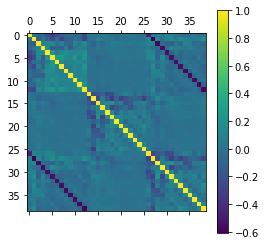

In [40]:
plt.matshow(corrcoef)
plt.colorbar()
plt.show()

## Make 512 mixture GMM

In [319]:
dupa.groups.keys()

dict_keys([32, 33, 34, 31])

In [37]:
# ubm = mixture.GaussianMixture(
#     n_components=512, max_iter=2000, covariance_type='diag', 
#     random_state=13, verbose=1
# )
# ubm.fit(untrialed_features_stack)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=2000,
        means_init=None, n_components=512, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [52]:
# write_model(root + '/models/ubm/ubm_model.pickle', ubm)

In [ ]:
ubm = read_model(root + '/models/ubm/ubm_model.pickle')

## Enroll

In [69]:
def build_stack(paths):
    features = [all_mfcc[path] for path in paths]
    return np.vstack(features)

speaker_paths = enrollments_1[enrollments_1.is_male & (enrollments_1.speaker_id == 1)].pcm_path
speaker_stack = build_stack(speaker_paths)
print(len(speaker_paths), speaker_stack.shape)

30 (8498, 39)


In [144]:
def load_ubm_copy():
    return read_model(root + '/models/ubm/ubm_model.pickle')

In [148]:
def map_adapt(gmm, features, relevance_factor=3.0):
    proba = gmm.predict_proba(features)
    zero_stats = proba.sum(axis=0)
    first_stats = proba.T @ features
    new_means = first_stats / zero_stats[:, np.newaxis]
    new_means[~np.isfinite(new_means)] = gmm.means_[~np.isfinite(new_means)]
    replace_factor = zero_stats / (zero_stats + relevance_factor)
    adapted_means = gmm.means_ + replace_factor[:, np.newaxis] * (new_means - gmm.means_)
    gmm.means_ = adapted_means
    
# example_ubm_copy = load_ubm_copy()
# map_adapt(example_ubm_copy, speaker_stack)
# example_ubm_copy

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=2000,
        means_init=None, n_components=512, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [257]:
def split_enrollments(enrollments):
    unique_males = enrollments[enrollments.is_male].speaker_id.unique()
    unique_females = enrollments[~enrollments.is_male].speaker_id.unique()
    unique_sentences = enrollments.sentence_id.unique()
    return unique_males, unique_females, unique_sentences

def enroll_speakers(enrollments):
    males, females, _ = split_enrollments(enrollments)
    
    speaker_gmms = {}
    for is_male, speaker_ids in ((True, males), (False, females)):
        for speaker_id in speaker_ids:
            speaker_mask = (enrollments.is_male == is_male) & (enrollments.speaker_id == speaker_id)
            speaker_paths = enrollments[speaker_mask].pcm_path
            speaker_gmm = load_ubm_copy()
            speaker_stack = build_stack(speaker_paths)
            map_adapt(speaker_gmm, speaker_stack)
            speaker_gmms[(is_male, speaker_id)] = speaker_gmm
            
    return speaker_gmms

def enroll_sentences(enrollments):
    _, _, sentence_ids = split_enrollments(enrollments)
    
    sentence_gmms = {}
    for sentence_id in sentence_ids:
        sentence_mask = enrollments.sentence_id == sentence_id
        sentence_paths = enrollments[sentence_mask].pcm_path
        sentence_gmm = load_ubm_copy()
        sentence_stack = build_stack(sentence_paths)
        map_adapt(sentence_gmm, sentence_stack)
        sentence_gmms[sentence_id] = sentence_gmm
            
    return sentence_gmms

In [160]:
enrollments1_speaker_gmms = enroll_speakers(enrollments_1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [258]:
enrollments1_sentence_gmms = enroll_sentences(enrollments_1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


## Trial

In [255]:
def save_results(label, results):
    path = os.path.join(root, 'result', 'ubm', label)
    with open(path, 'wb') as opened:
        pickle.dump(results, opened)
        
def load_results(label):
    path = os.path.join(root, 'result', 'ubm', label)
    with open(path, 'rb') as opened:
        return pickle.load(opened)

In [165]:
def score_ratio(ubm, speaker_gmm, recording):
    ubm_score = ubm.score(recording)
    speaker_score = speaker_gmm.score(recording)
    return np.exp(speaker_score - max(ubm_score, speaker_score))

# shit_trial = trials_1[trials_1.trial_is_male & (trials_1.trial_speaker_id == 1)].iloc[5]
# shit_mfcc = all_mfcc[shit_trial.pcm_path]
# print(ubm.score(shit_mfcc), ubm.score_samples(shit_mfcc).shape)

In [180]:
ubm_scores = {path: ubm.score(all_mfcc[path]) for path in trialed_paths}

In [200]:
all_mfcc['f0011/20150622072545004_f0011_34.pcm'].shape

(8, 39)

In [271]:
def gather_results(ubm_scores, speaker_scores, sentence_scores, speaker_gmms, sentence_gmms, trials):
    size = len(trials)
    
    scores = np.zeros((size, 4), dtype=np.float64)
    flags = np.zeros((size, 6), dtype=np.bool)
    
    for i, trial in trials.iterrows():
        try:
            ubm_score = ubm_scores[trial.pcm_path]
        except KeyError:
            flags[i, 5] = True
            continue
            
        key = (trial.expected_is_male, trial.expected_speaker_id, trial.pcm_path)
        if key in speaker_scores:
            speaker_score = speaker_scores[key]
        else:
            speaker_gmm = speaker_gmms[(trial.expected_is_male, trial.expected_speaker_id)]
            recording = all_mfcc[trial.pcm_path]
            speaker_score = speaker_gmm.score(recording)
            speaker_scores[key] = speaker_score
            
        key2 = (trial.expected_sentence_id, trial.pcm_path)
        if key2 in sentence_scores:
            sentence_score = sentence_scores[key2]
        else:
            sentence_gmm = sentence_gmms[trial.expected_sentence_id]
            recording = all_mfcc[trial.pcm_path]
            sentence_score = sentence_gmm.score(recording)
            sentence_scores[key2] = sentence_score
            
        score = np.exp(speaker_score - max(ubm_score, speaker_score) 
                     + sentence_score - max(ubm_score, sentence_score))
        
        expected_is_male = trial.expected_is_male
        trial_is_male = trial.trial_is_male
        gender_right = trial.expected_is_male == trial.trial_is_male
        target_right = gender_right and (trial.expected_speaker_id == trial.trial_speaker_id)
        sentence_right = trial.expected_sentence_id == trial.trial_sentence_id
        
        scores[i, :] = (speaker_score, sentence_score, ubm_score, score)
        flags[i, :] = (expected_is_male, trial_is_male, gender_right, target_right, sentence_right, False)
        
    return pd.DataFrame.from_dict({
        'speaker_score': scores[:, 0], 'sentence_score': scores[:, 1], 'ubm_score': scores[:, 2], 
        'score': scores[:, 3],
        'expected_is_male': flags[:, 0], 'trial_is_male': flags[:, 1], 'gender_right': flags[:, 2],
        'target_right': flags[:, 3], 'sentence_right': flags[:, 4], 'too_short': flags[:, 5]
    })

In [246]:
speaker_scores = {}
sentence_scores = {}

In [272]:
trials_1_results = gather_results(ubm_scores, speaker_scores, sentence_scores, 
                                  enrollments1_speaker_gmms, enrollments1_sentence_gmms, trials_1)

In [269]:
# save_results('speaker_scores.pickle', speaker_scores)
# save_results('sentence_scores.pickle', sentence_scores)
# trials_1_results.to_pickle(os.path.join(root, 'result', 'ubm', 'trials_1_results.pickle.gz'), compression='gzip')

In [274]:
trials_1_results = pd.read_pickle(os.path.join(root, 'result', 'ubm', 'trials_1_results.pickle.gz'), compression='gzip')
trials_1_speakeronly_results = pd.read_pickle(os.path.join(root, 'result', 'ubm', 'trials_1_results_speakeronly.pickle.gz'), compression='gzip')

# Visualize

In [294]:
def equal_error_rate(fpr, tpr, thresholds):
    eer = optimize.brentq(lambda x : 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
    threshold = interpolate.interp1d(fpr, thresholds)(eer)
    return eer, threshold

def plot_roc(fpr, tpr, auc, eer, title):
    plt.figure(figsize=(8, 6))
    print(auc, eer)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = {:.2%}, EER = {:.2%})'.format(auc, eer))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
def visualize_roc(fpr, tpr, thresholds, title=None):
    roc_auc = metrics.auc(fpr, tpr)
    eer, threshold = equal_error_rate(fpr, tpr, thresholds)
    plot_roc(fpr, tpr, roc_auc, eer, title=title)
    
def visualize_results(results):
    # is target right, disregarding sentence
    roc_target_right = metrics.roc_curve(results.target_right, results.speaker_prob)
    visualize_roc(*roc_target_right, title='ROC - speaker correct problem')

    # is sentence correct or wrong, disregarding target
    roc_sentence_right = metrics.roc_curve(results.sentence_right, results.sentence_prob)
    visualize_roc(*roc_sentence_right, title='ROC - sentence correct problem')

    # is target right, when the sentence is correct
    roc_both_right = metrics.roc_curve(results.target_right & results.sentence_right, results.both_prob)
    visualize_roc(*roc_both_right, title='ROC - speaker and sentence correct problem')

In [293]:
trials_1_results['speaker_prob'] = np.exp(trials_1_results.speaker_score - np.maximum(trials_1_results.ubm_score, trials_1_results.speaker_score))
trials_1_results['sentence_prob'] = np.exp(trials_1_results.sentence_score - np.maximum(trials_1_results.ubm_score, trials_1_results.sentence_score))
trials_1_results['both_prob'] = trials_1_results.score

0.975591922404 0.04688871675703585


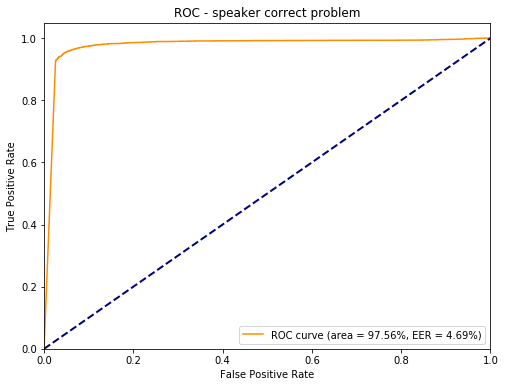

0.978183232102 0.06043008180017423


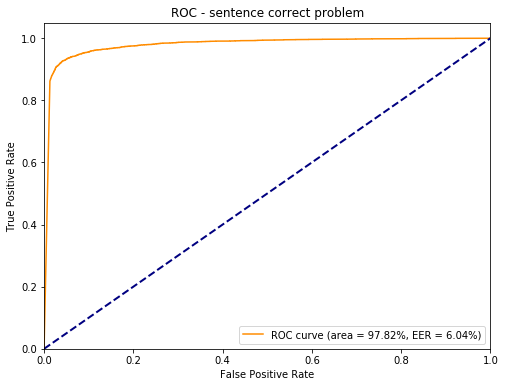

0.990371020263 0.032016524657887985


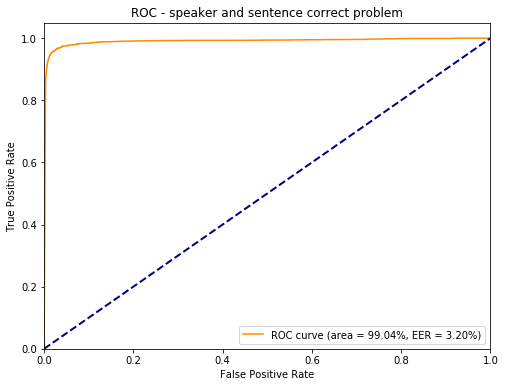

In [295]:
visualize_results(trials_1_results[~trials_1_results.too_short])